<a href="https://colab.research.google.com/github/arpdm/predictive-maintenance-platform/blob/main/experiment_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive/")

!cp drive/MyDrive/PdM/predictive-maintenance-platform/engine_data.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/plot_util.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/mark_001_model.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/pcoe_engine_data_visualizer.py .

Mounted at /content/drive/


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time

from engine_data import EngineData
from pcoe_engine_data_visualizer import PcoeEngingeVis
from plot_util import PlotUtil
from mark_001_model import Mark001Model

In [4]:
# Load all datasets
BASE_PATH = "/content/drive/MyDrive/PdM/data_set/"

DS_001 = BASE_PATH + "N-CMAPSS_DS01-005.h5"
DS_002 = BASE_PATH + "N-CMAPSS_DS02-006.h5"
DS_003 = BASE_PATH + "N-CMAPSS_DS03-012.h5"
DS_004 = BASE_PATH + "N-CMAPSS_DS04.h5"
DS_005 = BASE_PATH + "N-CMAPSS_DS05.h5"
DS_006 = BASE_PATH + "N-CMAPSS_DS06.h5"
DS_007 = BASE_PATH + "N-CMAPSS_DS07.h5"
DS_008 = BASE_PATH + "N-CMAPSS_DS08a-009.h5"
DS_009 = BASE_PATH + "N-CMAPSS_DS08c-008.h5"
DS_010 = BASE_PATH + "N-CMAPSS_DS08d-010.h5"

In [ ]:
# Load data set and prepare data frames
ed = EngineData()
pcoe_enging_vis = PcoeEngingeVis(ed)
plot_util = PlotUtil()
mark_001 = Mark001Model()

In [ ]:
# Dataset load block
ed.load_hdf5_to_numpy_arr(DS_001)
ed.df_x_s_train = ed.add_labels_to_dataset(ed.df_x_s_train)
ed.df_x_s_train = ed.normalize_dataset(ed.df_x_s_train)
ed.df_x_s_test = ed.add_labels_to_dataset(ed.df_x_s_test)
ed.df_x_s_test = ed.normalize_dataset(ed.df_x_s_test)

## Experiment 003

**Experiment goal:** Tune the Learning Rate

**Approach:** We will use logarithmic scale to generate random learning rates and train/validate/test with each learning rate.

In [7]:
# learning_rates = [4e-4,5e-4,6e-4,7e-4]
learning_rates = [6e-4, 7e-4]

In [8]:
# Model build block
window = 50
batch_size = 256
epochs = 40
steps = 100
patience_epoch = 10
data_path = "/content/drive/MyDrive/PdM/model_generated_data"
features = ed.df_x_s_train.columns.drop(["RUL", "label1", "label2", "cycle", "id"]).size


def train(learning_rate):

    # Hyperparameters required for ADAM Optimizer
    adam_params = {
        "learning_rate": learning_rate,
        "beta_1": 0.9,
        "beta_2": 0.999,
        "epsilon": 1e-8,
    }

    model_mark_001 = mark_001.create_binary_classifier_model(
        window,
        features,
        units_first_layer=100,
        units_second_layer=50,
        dropout_rate=0.2,
        optimizer_hyperparams=adam_params,
        adam_w_enabled=False,
    )

    for engine_unit in np.unique(ed.df_aux_train["unit"]):
        ## Training Block
        single_engine_train = ed.generate_data_frame_for_specific_engine(ed.df_x_s_train, engine_unit)
        x_train, y_train = ed.generate_x_y_model_inputs(single_engine_train, window=window)

        mark_001_history = mark_001.fit_model(x_train, y_train, epochs, steps, batch_size, patience_epoch)
        plot_util.generate_training_history_accuracy_and_loss_plot(mark_001_history, data_path)

In [9]:
def test():
    for engine_unit in np.unique(ed.df_aux_test["unit"]):
        ## Test Block
        print("========================================================================================")
        single_engine_test = ed.generate_data_frame_for_specific_engine(ed.df_x_s_test, engine_unit)
        x_test, y_test = ed.generate_x_y_model_inputs(single_engine_test, window=window)

        (y_pred, y_true, cm) = mark_001.test_model(x_test, y_test)
        print(f"Y_Pred Failure Cycle: { np.where(y_pred==1)[0][0]}")
        print(f"Y_Ture Failure Cycle: { np.where(y_true==1)[0][0]}")
        # plot_util.generate_heat_map(cm)
        cm.head()
        # plot_util.generate_predicted_vs_true_plot(y_true, y_pred, "About To Fail")
        # plot_util.generate_about_to_fail_graphs(y_true, y_pred)

RUN 1 --- Learning Rate: 0.0006
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
100/100 [

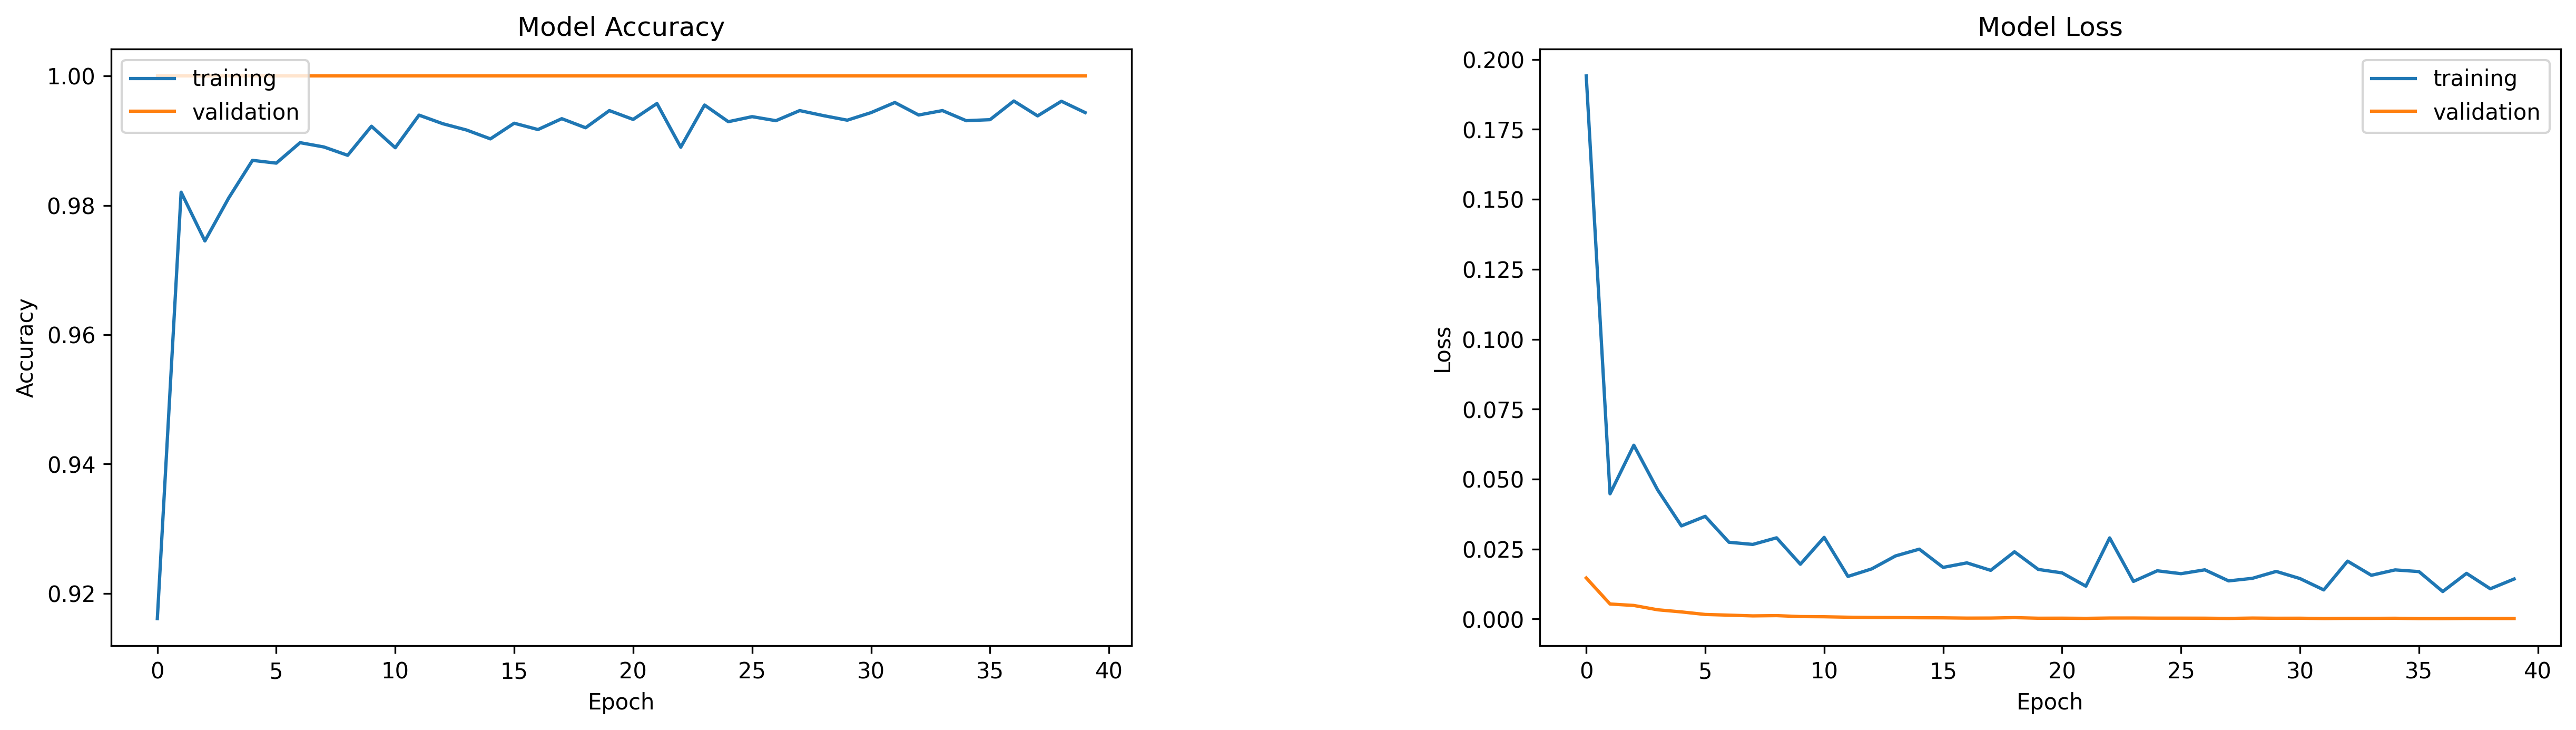

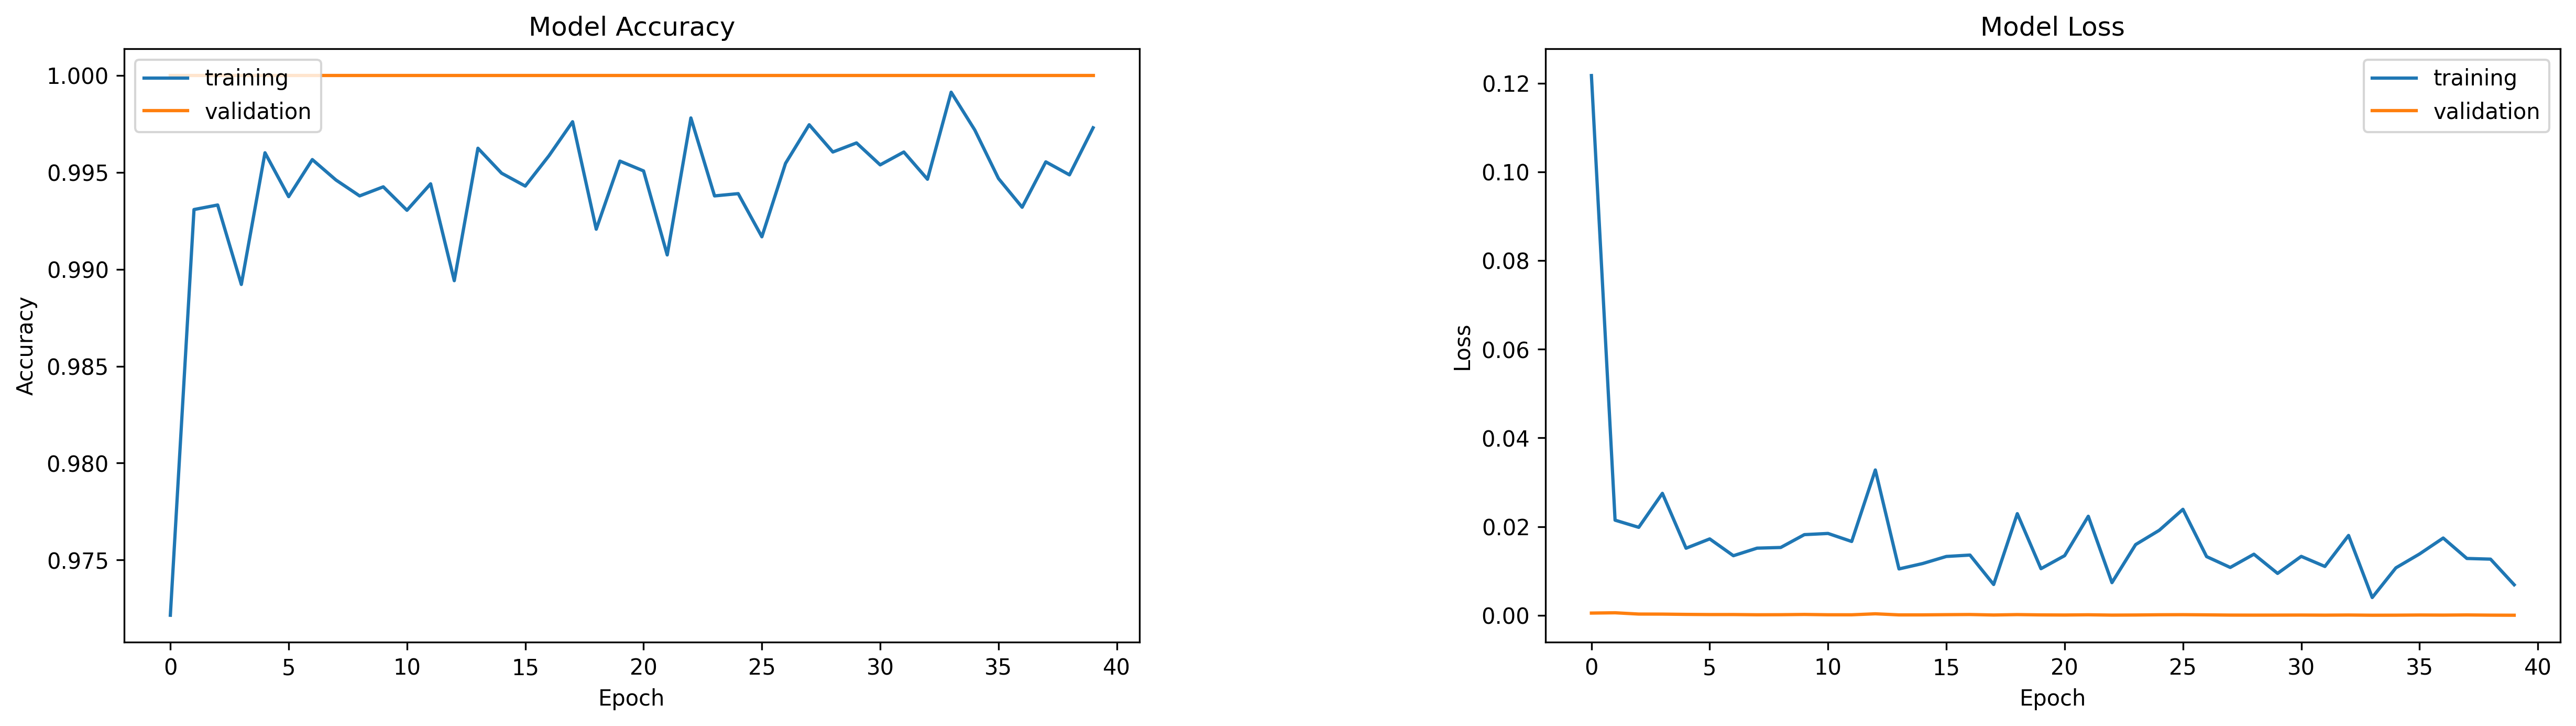

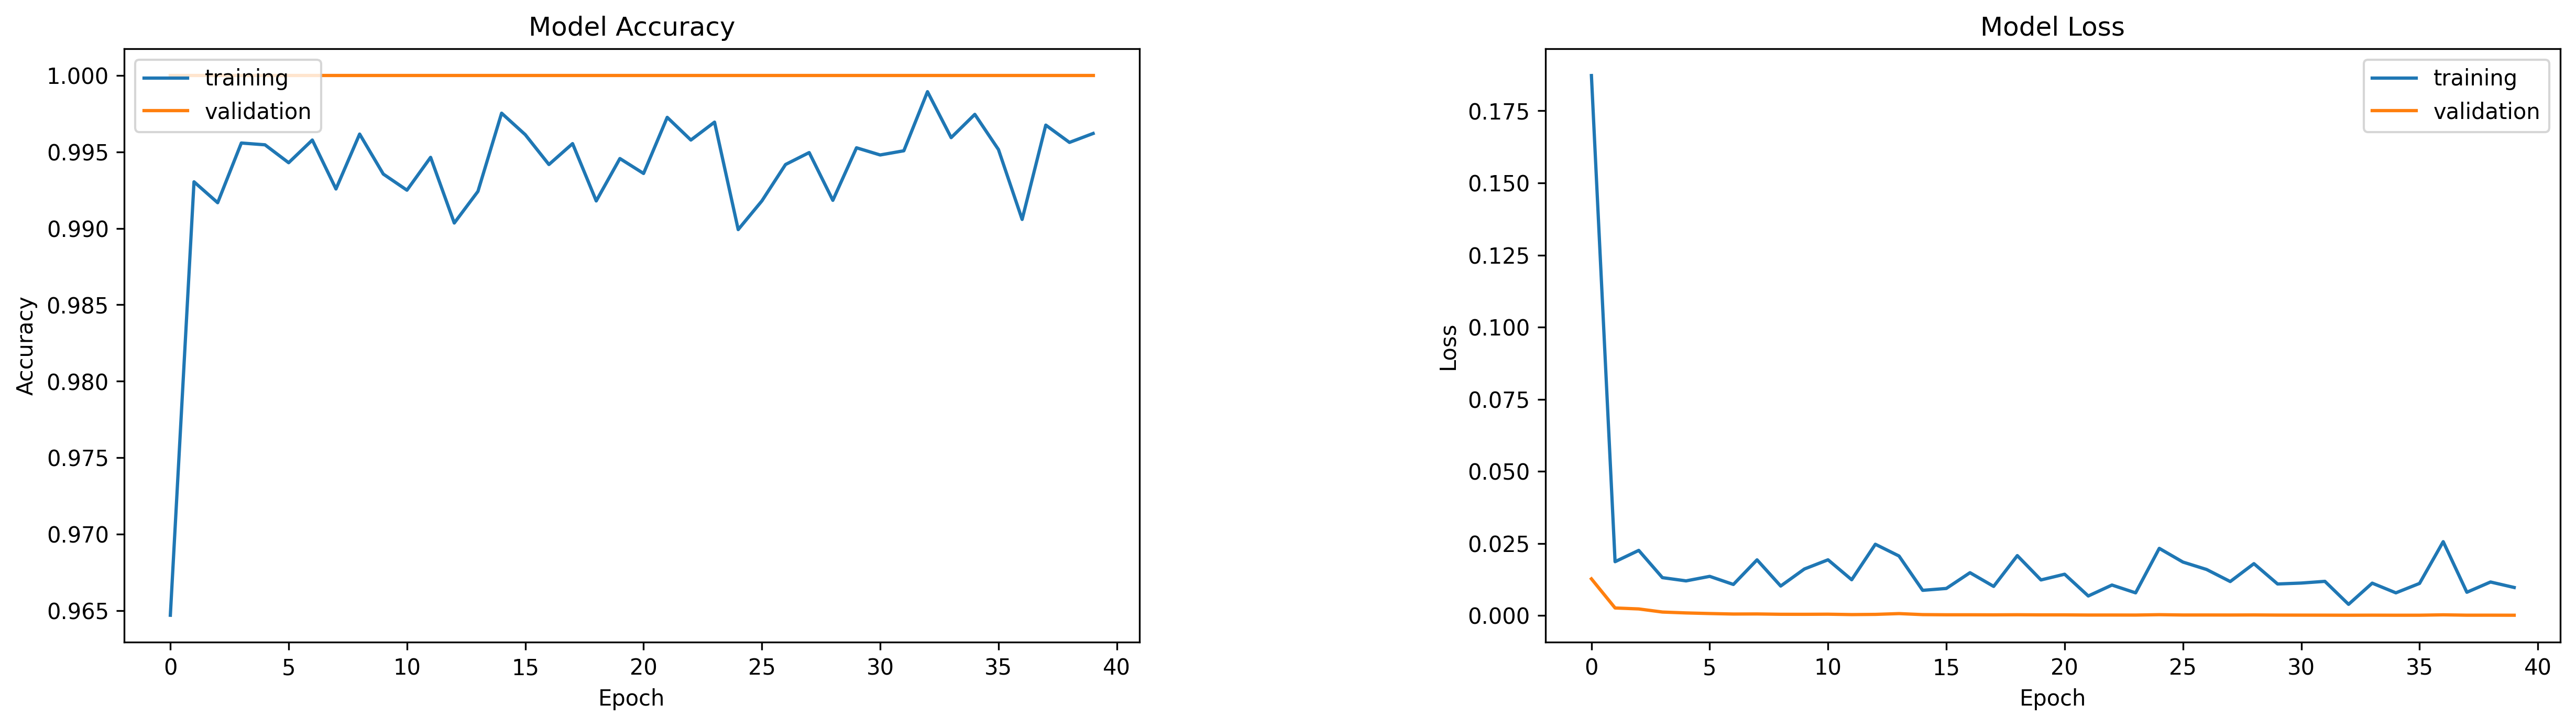

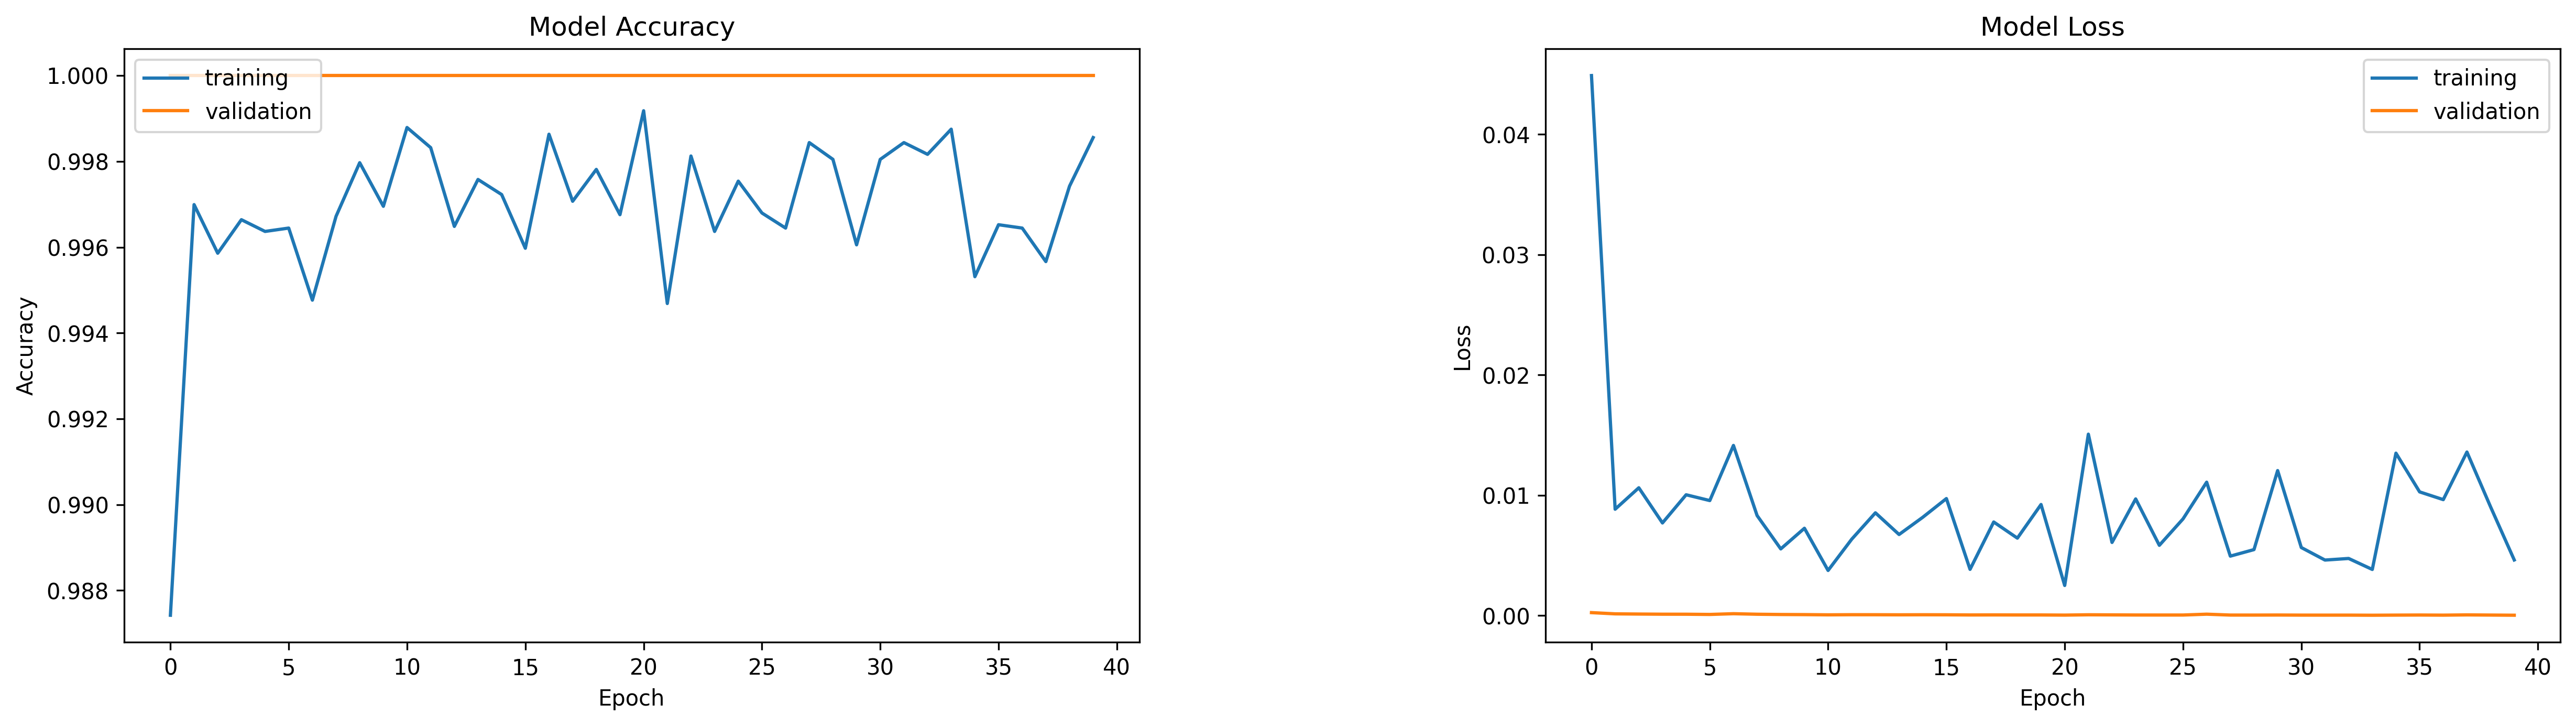

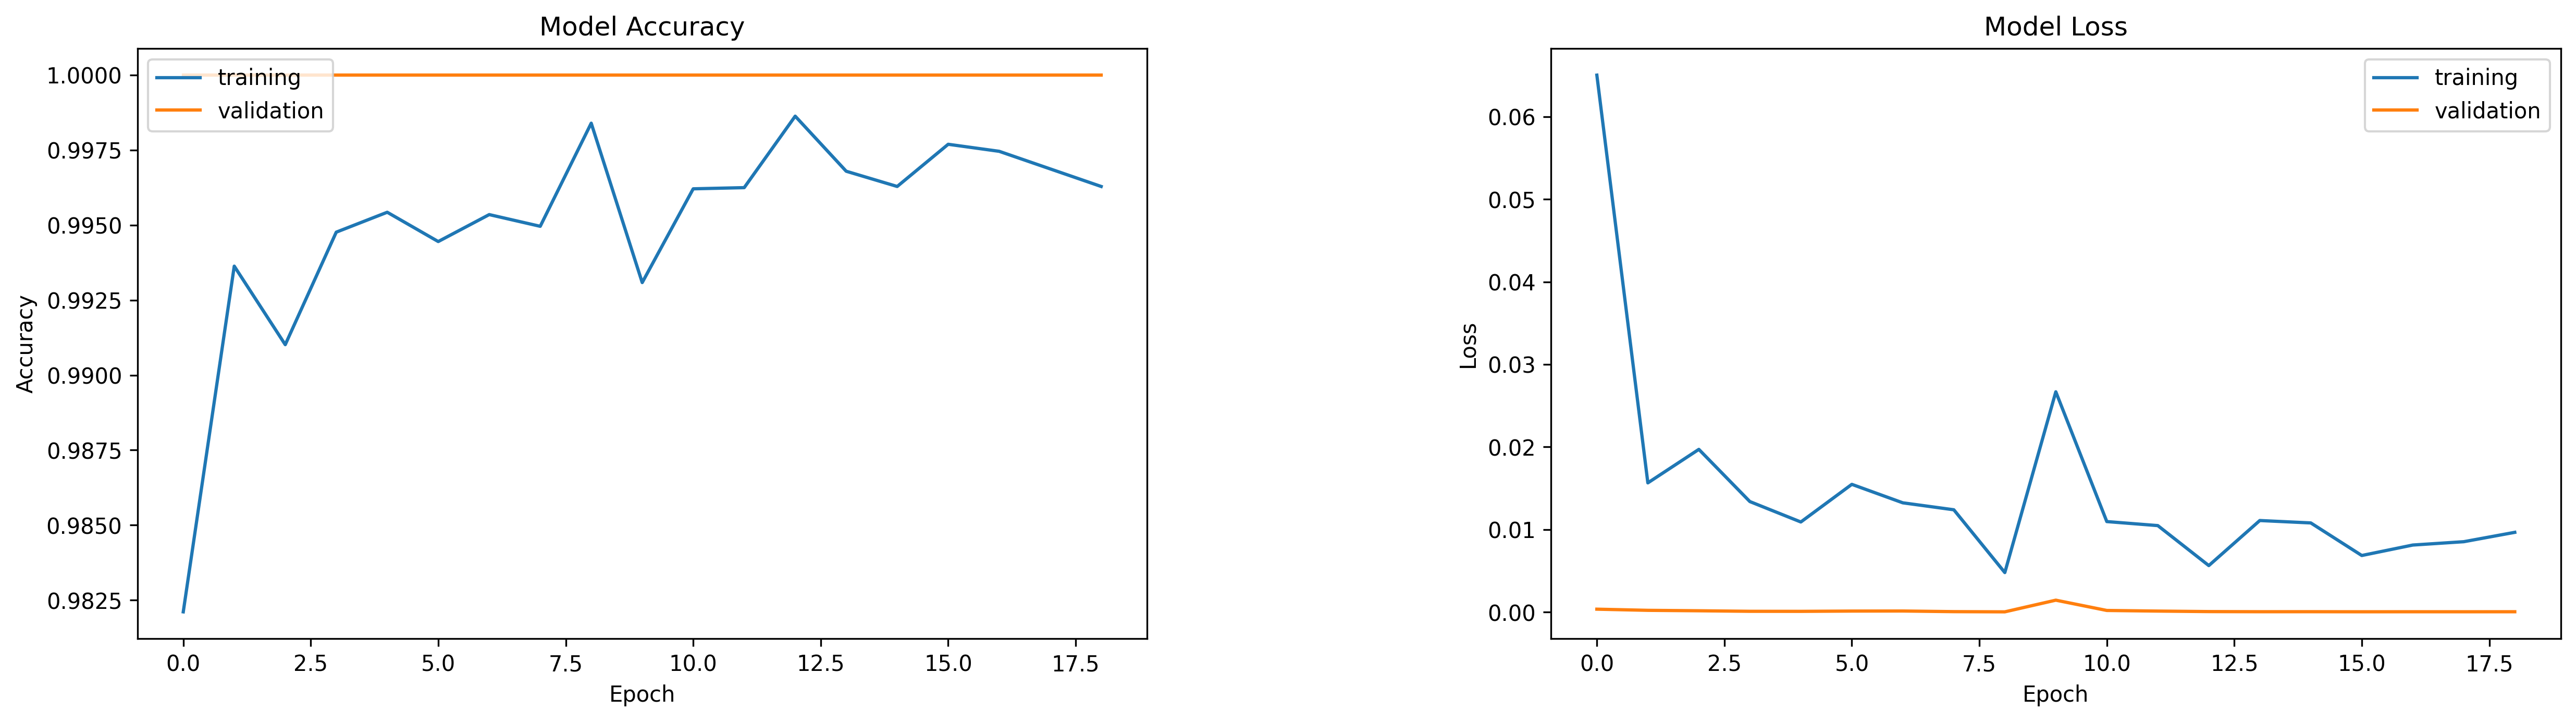

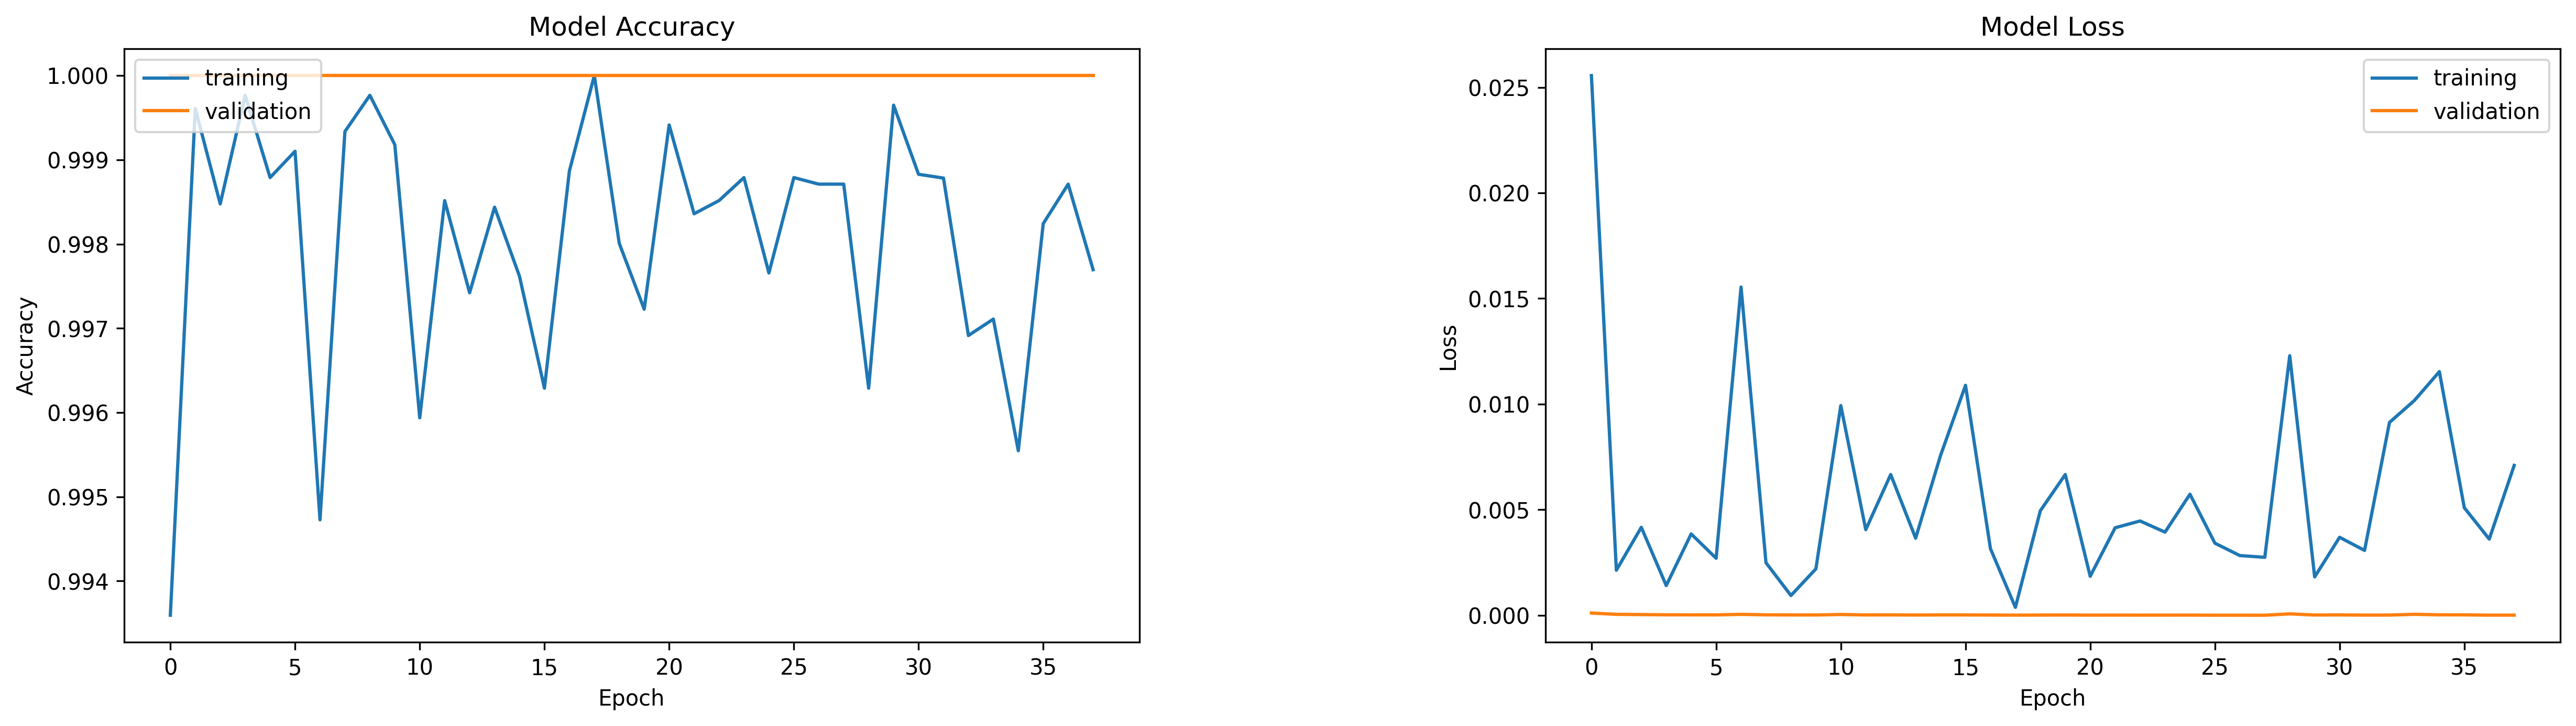

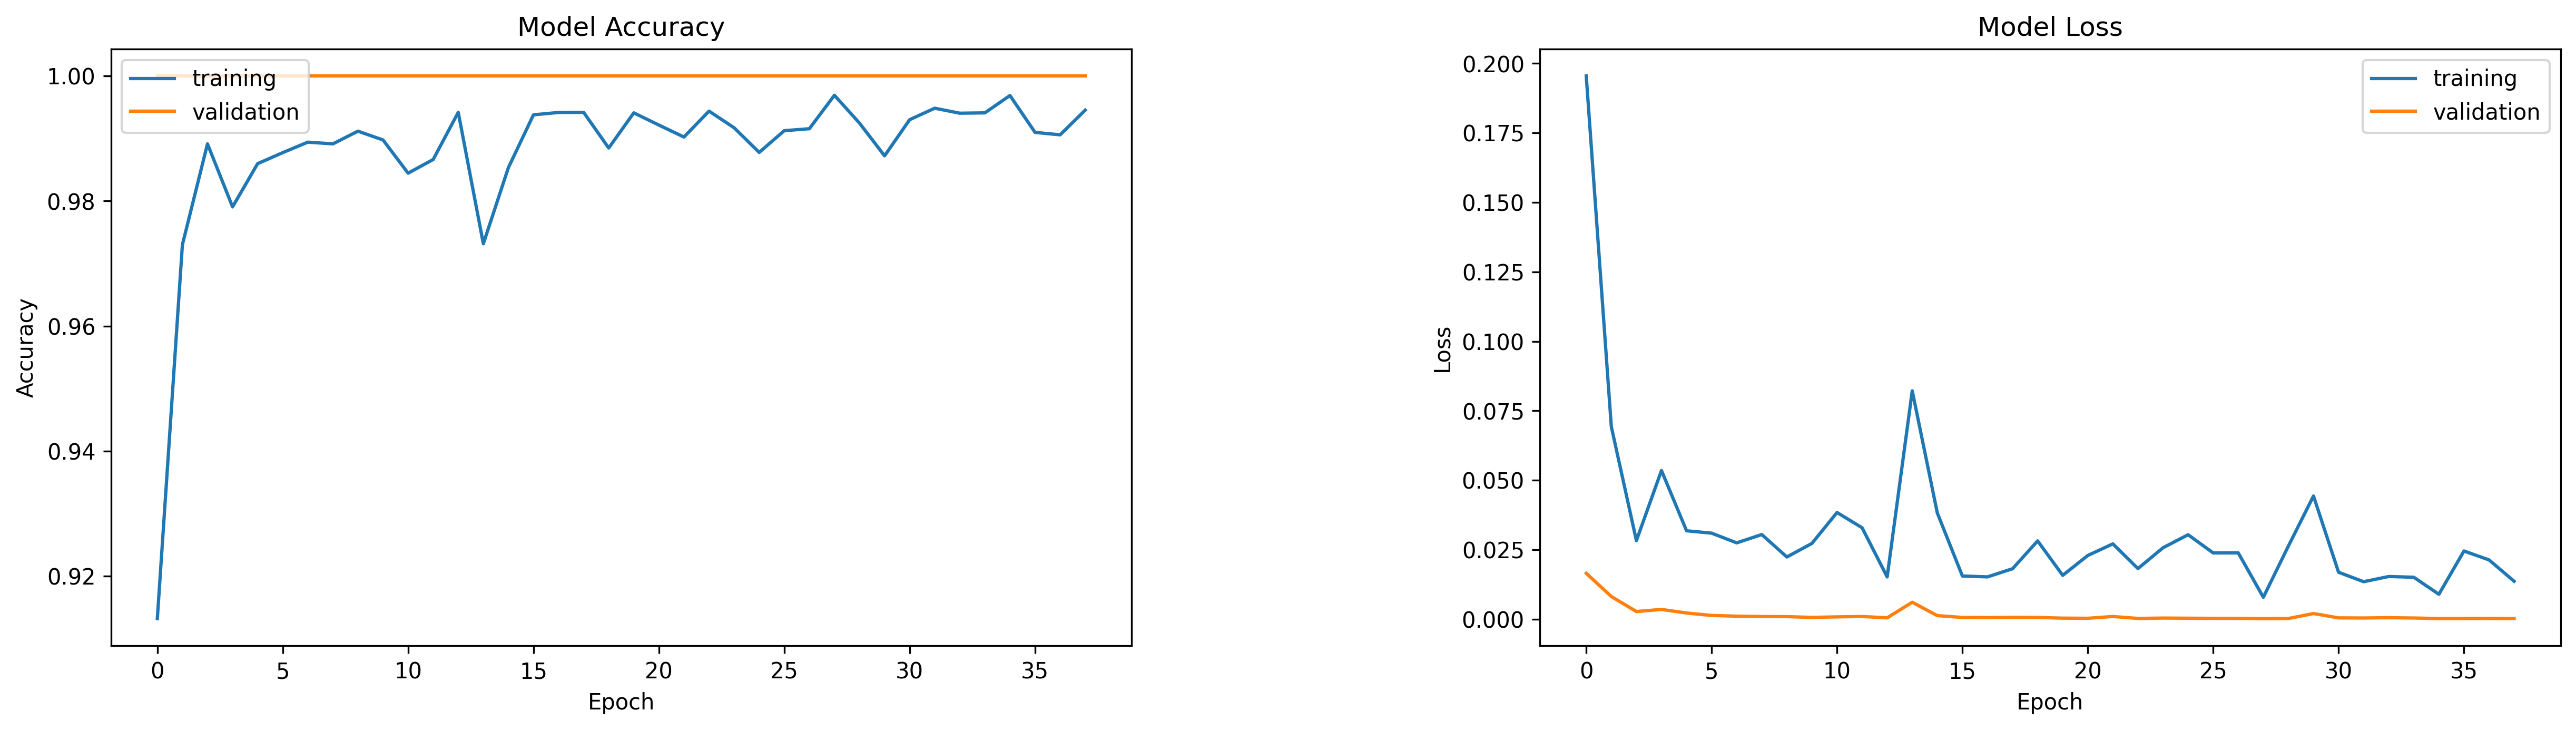

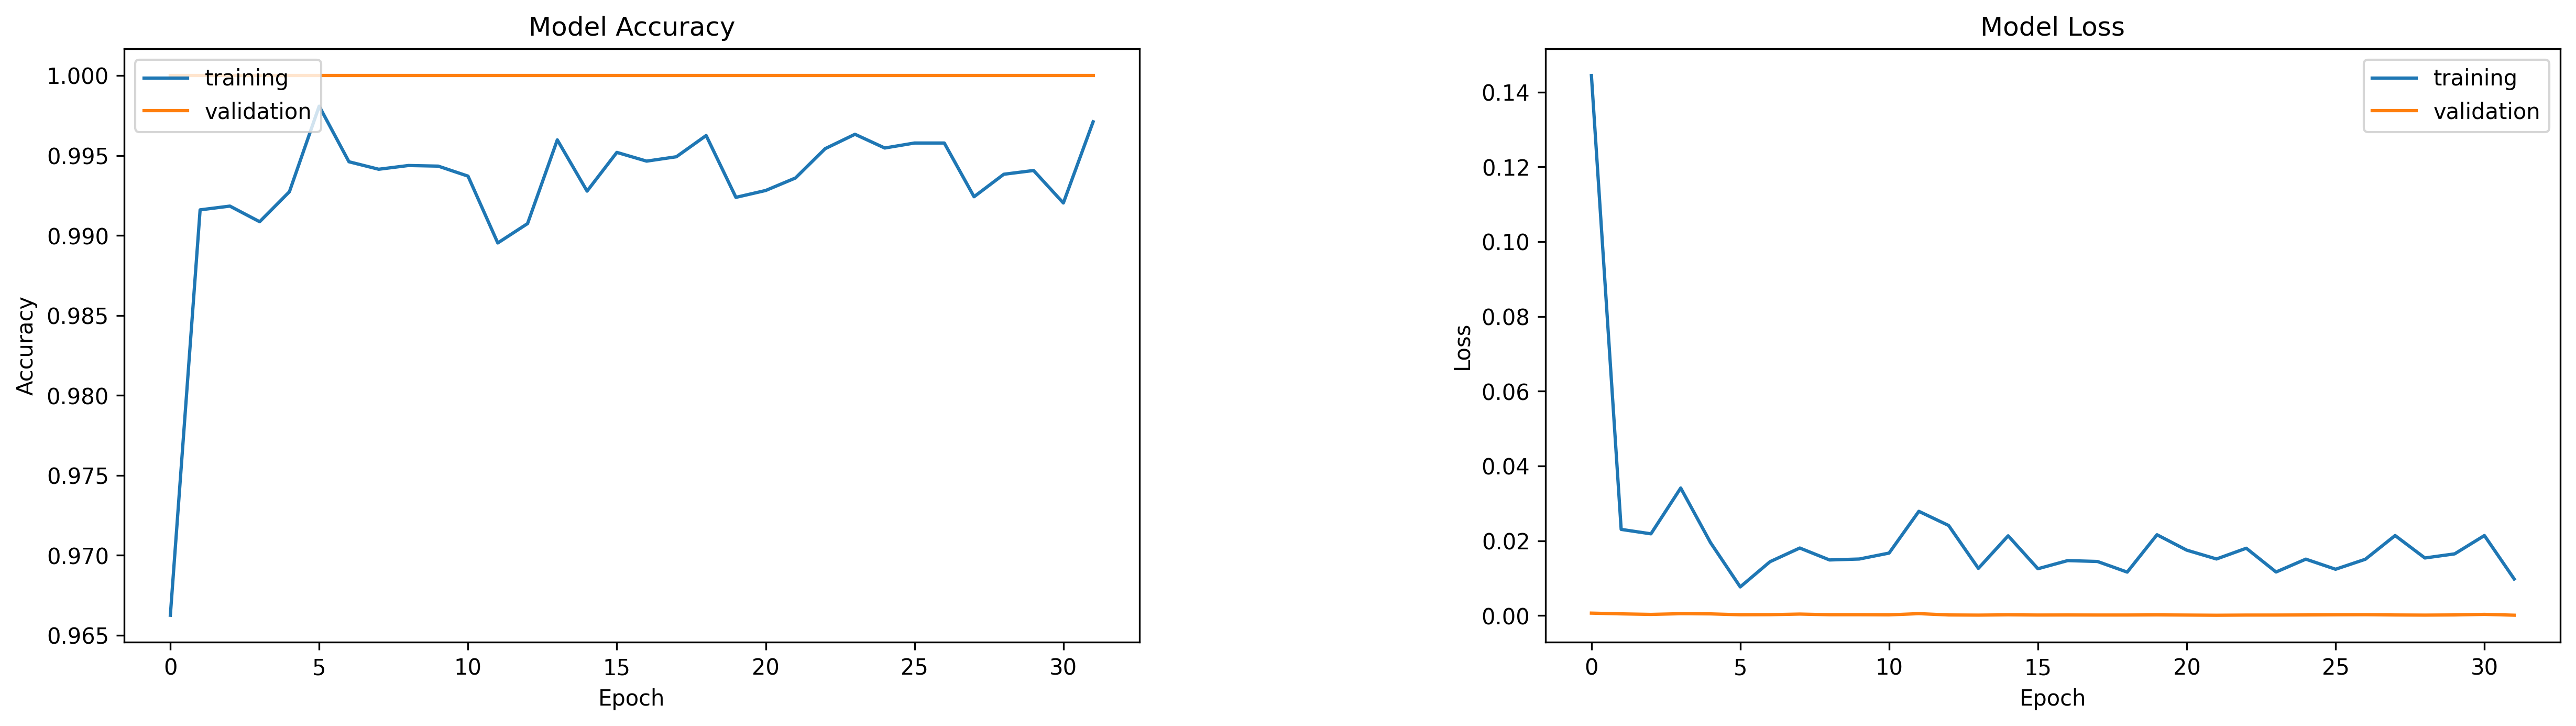

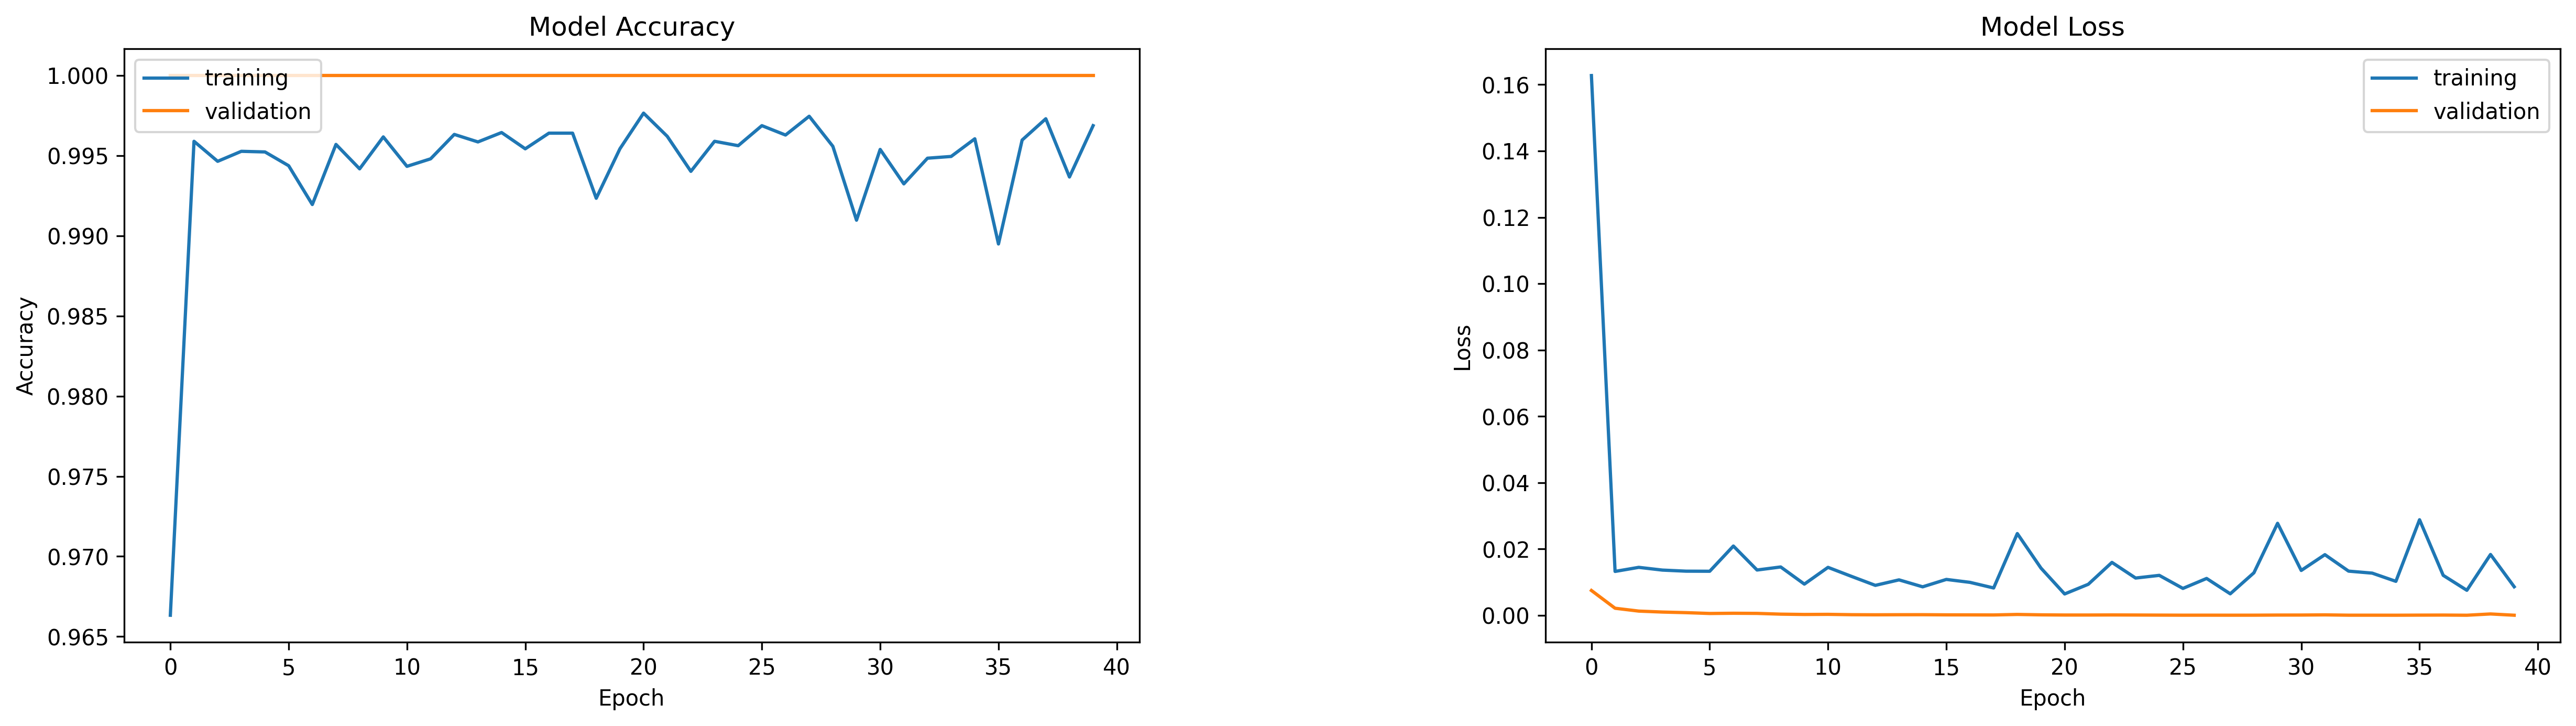

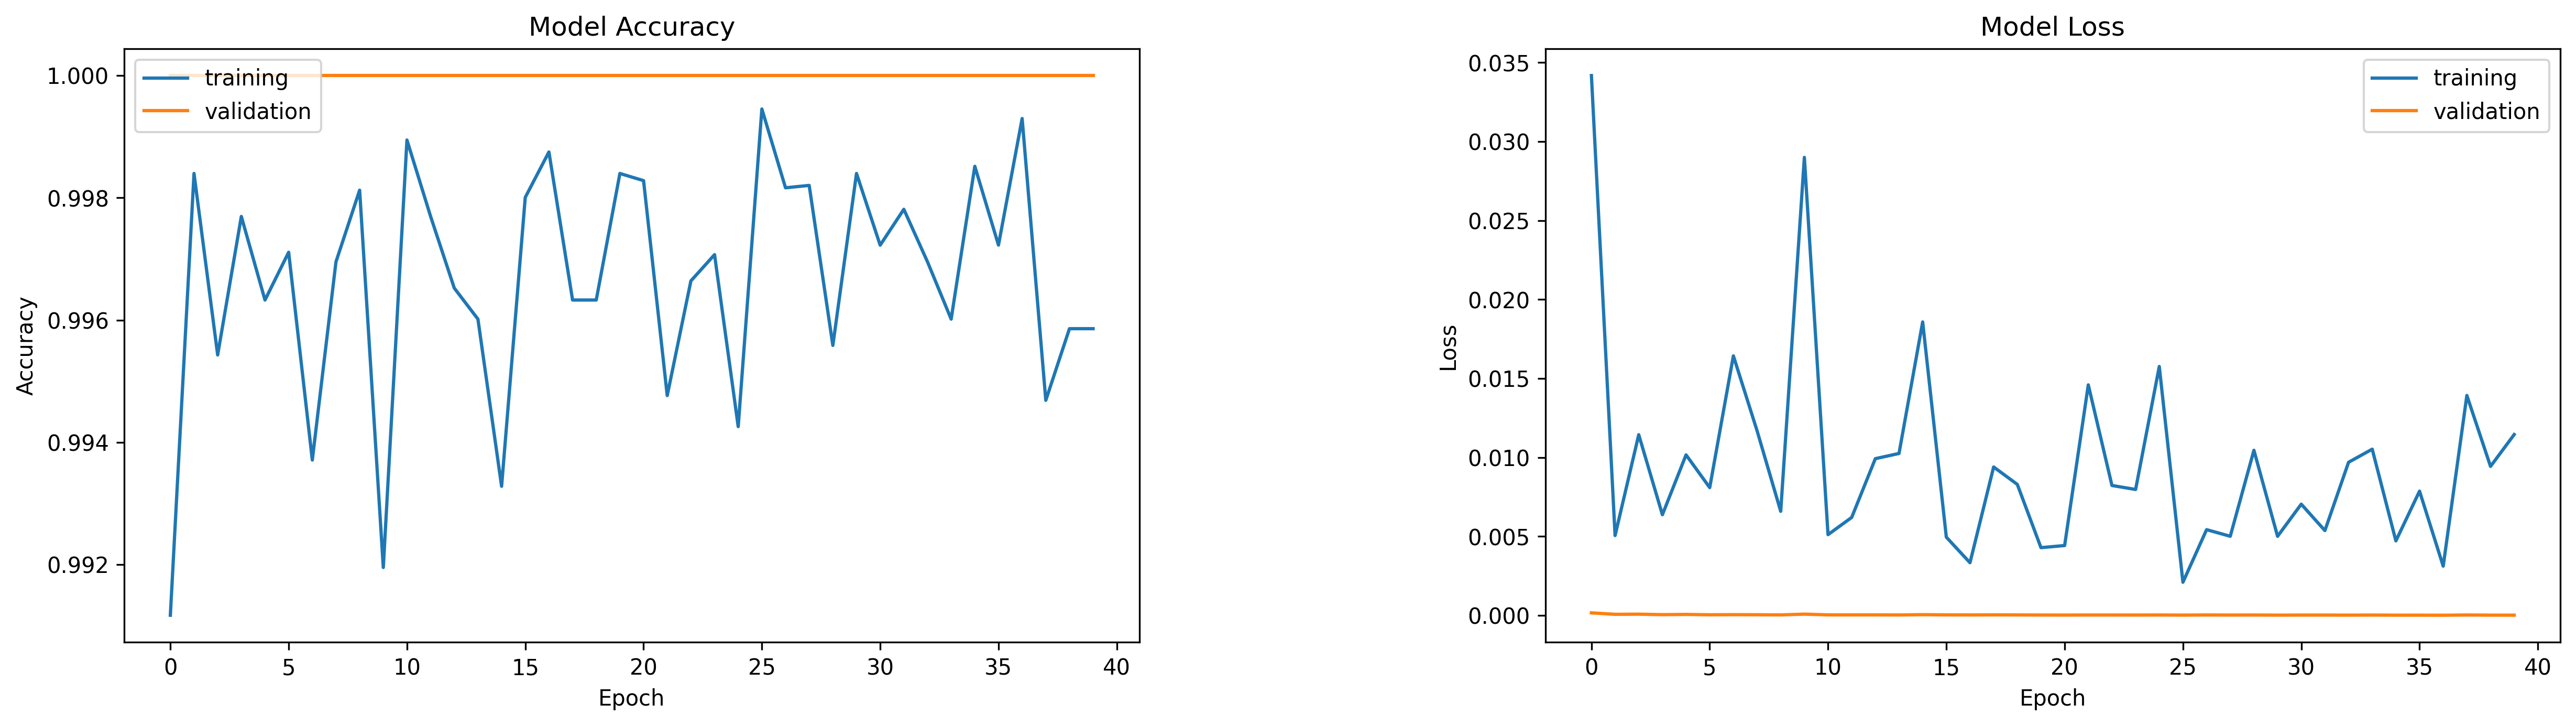

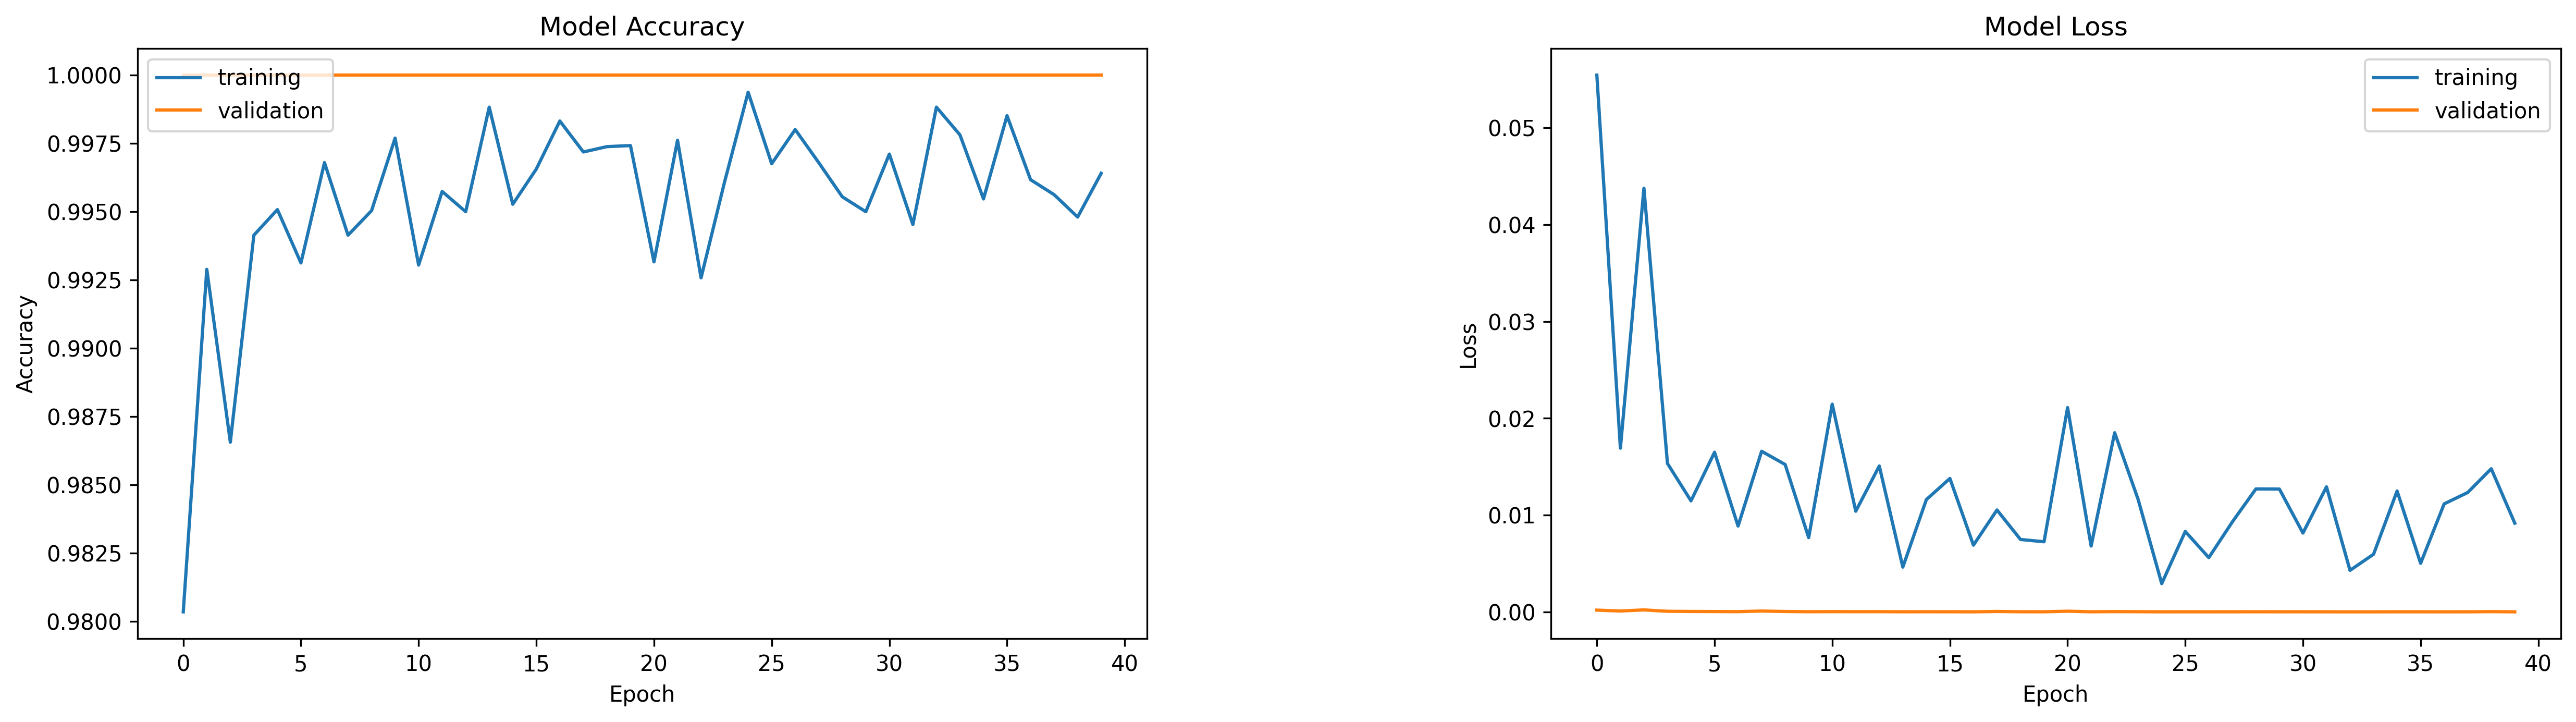

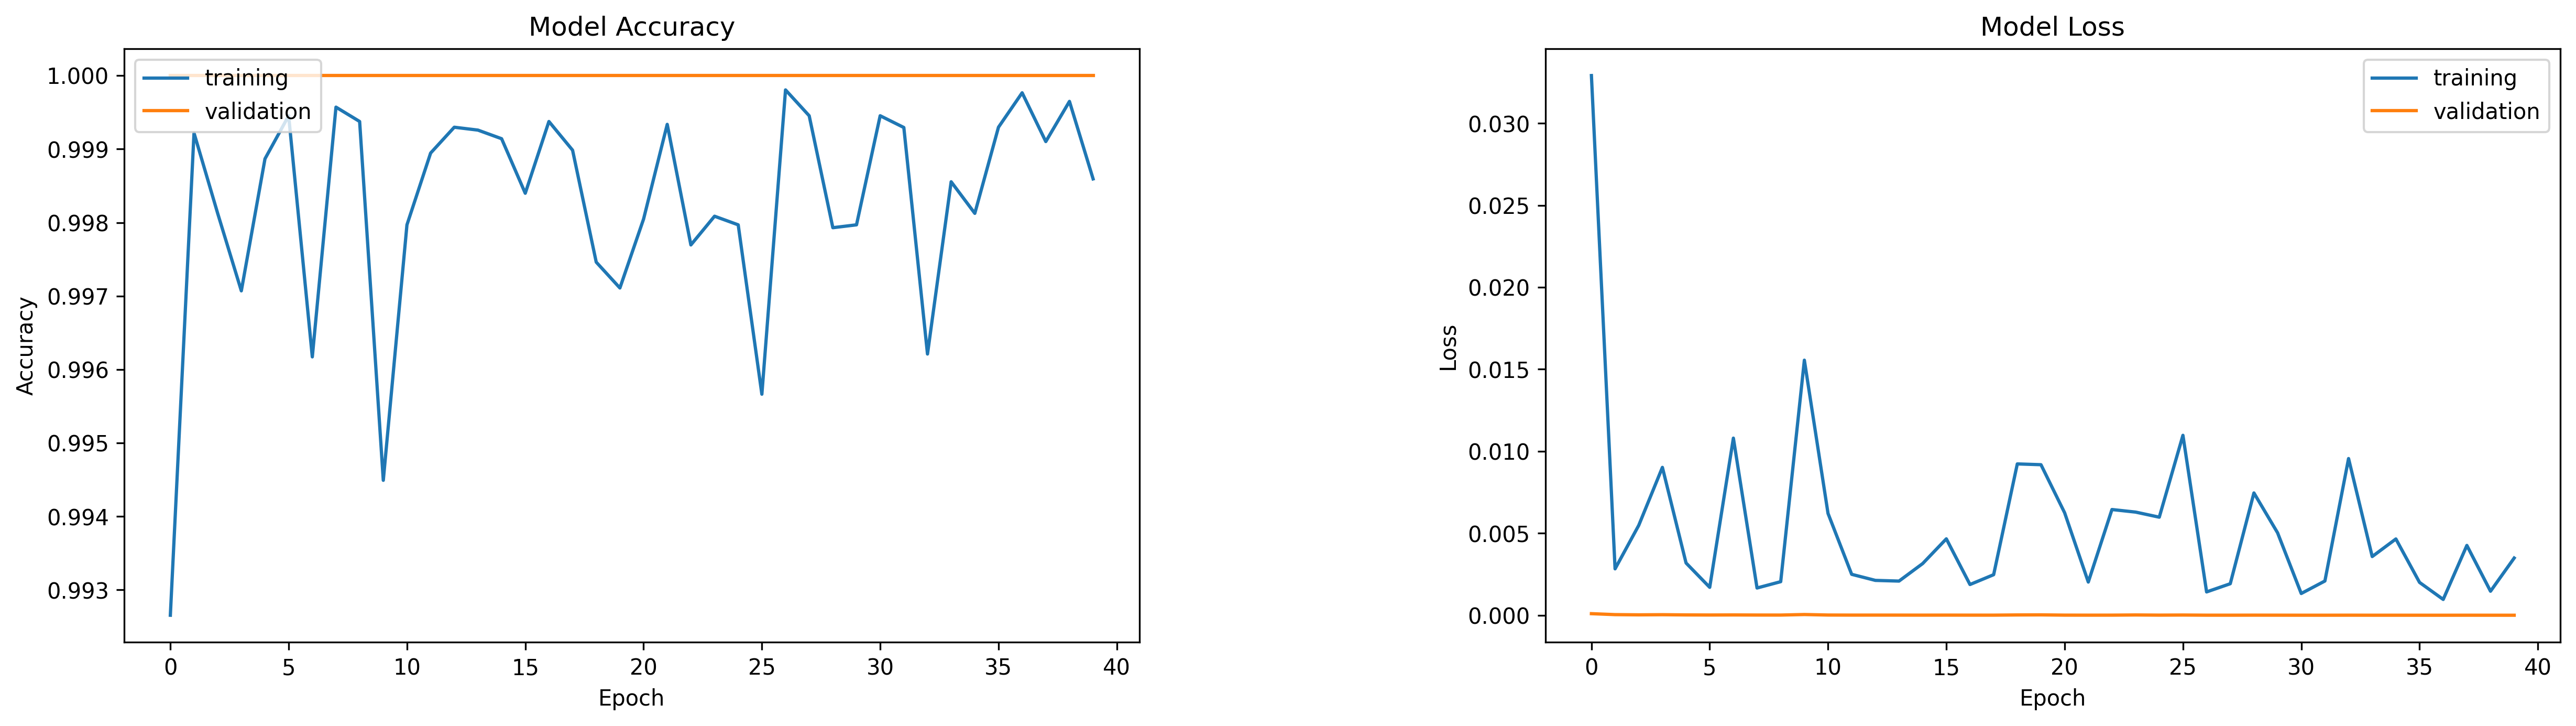

In [10]:
# EXP 03
count = 0
for r in learning_rates:
    count = count + 1
    print(f"RUN {count} --- Learning Rate: {r}")
    train(r)
    test()
    time.sleep(5)